In [2]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

### Iterate through the train and test directories to produce a train_df, a test_df and a valid_df


In [3]:
sdir=r'archive'
for dataset in ['test', 'train']:
    filepaths=[]
    labels=[]
    setpath=os.path.join(sdir, dataset)
    classlist=os.listdir(setpath)
    for klass in classlist:
        classpath=os.path.join(setpath, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    if dataset == 'test':
        test_df=df
    else:
        # split df into a train_df and a valid_df
        train_df, valid_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
        classes=sorted(list(train_df['labels'].unique()))        
        class_count = len(classes)
        print(' dataset contain ', class_count, ' classes listed below')
        print (classes)
        balance=list(train_df['labels'].value_counts())
        print ('Train_df image sample count in each class is shown below')
        print (balance)

 dataset contain  7  classes listed below
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Train_df image sample count in each class is shown below
[1755, 1270, 1232, 976, 596, 580, 431]
 dataset contain  7  classes listed below
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Train_df image sample count in each class is shown below
[1755, 1270, 1232, 976, 596, 580, 431]


### train_df is imbalance and has a large number of sample images. To balance the dataframe
### use the trim function below to limit the maximum number of samples in a class to value max_samples

In [4]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [5]:
max_samples=400
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)
working_dir=r'./'
img_size=(80,80)

Original Number of classes in dataframe:  7
[400, 400, 400, 400, 400, 400, 400]
Original Number of classes in dataframe:  7
[400, 400, 400, 400, 400, 400, 400]


### create train, test and valid generators

In [5]:
batch_size=40 # We will use and EfficientetB3 model, with image size of (300,233) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 2800 validated image filenames belonging to 7 classes.
Found 760 validated image filenames belonging to 7 classes.
Found 1860 validated image filenames belonging to 7 classes.
test batch size:  62   test steps:  30  number of classes :  7
       class name        class index 
          anger               0      
         disgust              1      
          fear                2      
        happiness             3      
         neutral              4      
         sadness              5      
        surprise              6      


### create a model using transfer learnimg using EfficientNetB3 as the base model

In [7]:
# Define image shape and model name
img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB5'

# Load the base model with EfficientNetB5
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Make the base model trainable
base_model.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(1024, 
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
x = Dense(128, 
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
lr = 0.001  # Start with this learning rate
model.compile(optimizer=Adamax(learning_rate=lr), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### define a custom callback to query user to either halt or continue training for  N more epochs

In [13]:
import time
import tensorflow as tf
from tensorflow.keras.models import Model

class ASK(tf.keras.callbacks.Callback):
    def __init__(self, epochs, ask_epoch):  # Initialization of the callback
        super(ASK, self).__init__()
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True  # If True, query the user on a specified epoch
        
    def on_train_begin(self, logs=None):  # This runs at the beginning of training
        if self.ask_epoch == 0: 
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:  # If ask_epoch is greater than the number of epochs
            print(f'ask_epoch >= epochs, will train for {self.epochs} epochs', flush=True)
            self.ask = False  # Do not query the user
        if self.epochs == 1:
            self.ask = False  # Running only for 1 epoch, so do not query user
        else:
            print(f'Training will proceed until epoch {self.ask_epoch}, then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run, then be asked again')
        self.start_time = time.time()  # Set the time at which training started
        
    def on_train_end(self, logs=None):  # Runs at the end of training
        tr_duration = time.time() - self.start_time  # Determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds'
        print(msg, flush=True)  # Print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # Method runs at the end of each epoch
        if self.ask:  # Are the conditions right to query the user?
            if epoch + 1 == self.ask_epoch:  # Is this epoch the one for querying the user?
                print('\nEnter H to end training or an integer for the number of additional epochs to run, then ask again')
                ans = input()
                
                if ans in ['H', 'h', '0']:  # Quit training for these conditions
                    print(f'You entered {ans}. Training halted on epoch {epoch + 1} due to user input\n', flush=True)
                    self.model.stop_training = True  # Halt training
                else:  # User wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print(f'\nYou specified maximum epochs as {self.epochs}, cannot train for {self.ask_epoch}', flush=True)
                    else:
                        print(f'You entered {ans}. Training will continue to epoch {self.ask_epoch}', flush=True)

# Define 2 useful Keras callbacks to control learning rate and early stopping. Instantiate the ASK callback
epochs = 40
ask_epoch = 5
ask = ASK(epochs, ask_epoch)
rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1, restore_best_weights=True)
callbacks = [rlronp, estop, ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000211B0AEE9D0>

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import time

# Assuming train_df, valid_df, and test_df are already defined and img_size is set

# Create train, test, and validation generators
batch_size = 40
trgen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
t_and_v_gen = ImageDataGenerator()

train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels
print('test batch size:', test_batch_size, 'test steps:', test_steps, 'number of classes:', class_count)
print('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

# Create a model using transfer learning with EfficientNetB5 as the base model
img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB5'

base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
x = Dense(128, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

lr = 0.001
model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

class ASK(tf.keras.callbacks.Callback):
    def __init__(self, epochs, ask_epoch):
        super(ASK, self).__init__()
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print(f'ask_epoch >= epochs, will train for {self.epochs} epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print(f'Training will proceed until epoch {self.ask_epoch}, then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run, then be asked again')
        self.start_time = time.time()
        
    def on_train_end(self, logs=None):
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds'
        print(msg, flush=True)
        
    def on_epoch_end(self, epoch, logs=None):
        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run, then ask again')
                ans = input()
                
                if ans in ['H', 'h', '0']:
                    print(f'You entered {ans}. Training halted on epoch {epoch + 1} due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print(f'\nYou specified maximum epochs as {self.epochs}, cannot train for {self.ask_epoch}', flush=True)
                    else:
                        print(f'You entered {ans}. Training will continue to epoch {self.ask_epoch}', flush=True)

epochs = 40
ask_epoch = 5
ask = ASK(epochs, ask_epoch)
rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1, restore_best_weights=True)
callbacks = [rlronp, estop, ask]

history = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=valid_gen, validation_steps=None, shuffle=False, initial_epoch=0)


Found 2800 validated image filenames belonging to 7 classes.
Found 2800 validated image filenames belonging to 7 classes.
Found 760 validated image filenames belonging to 7 classes.
Found 760 validated image filenames belonging to 7 classes.
Found 1860 validated image filenames belonging to 7 classes.
Found 1860 validated image filenames belonging to 7 classes.
test batch size: 62 test steps: 30 number of classes: 7
       class name        class index 
          anger               0      
         disgust              1      
          fear                2      
        happiness             3      
         neutral              4      
         sadness              5      
        surprise              6      
test batch size: 62 test steps: 30 number of classes: 7
       class name        class index 
          anger               0      
         disgust              1      
          fear                2      
        happiness             3      
         neutral              

ImportError: Loading a H5 file requires `h5py` to be installed.

ImportError: Loading a H5 file requires `h5py` to be installed.

AttributeError: property 'model' of 'ASK' object has no setter

### Train the model. Note unlike how you are told it is BETTER to make the base model trainable from the outset

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000211AC82F6F0>

### define a funcion to plot the training results******

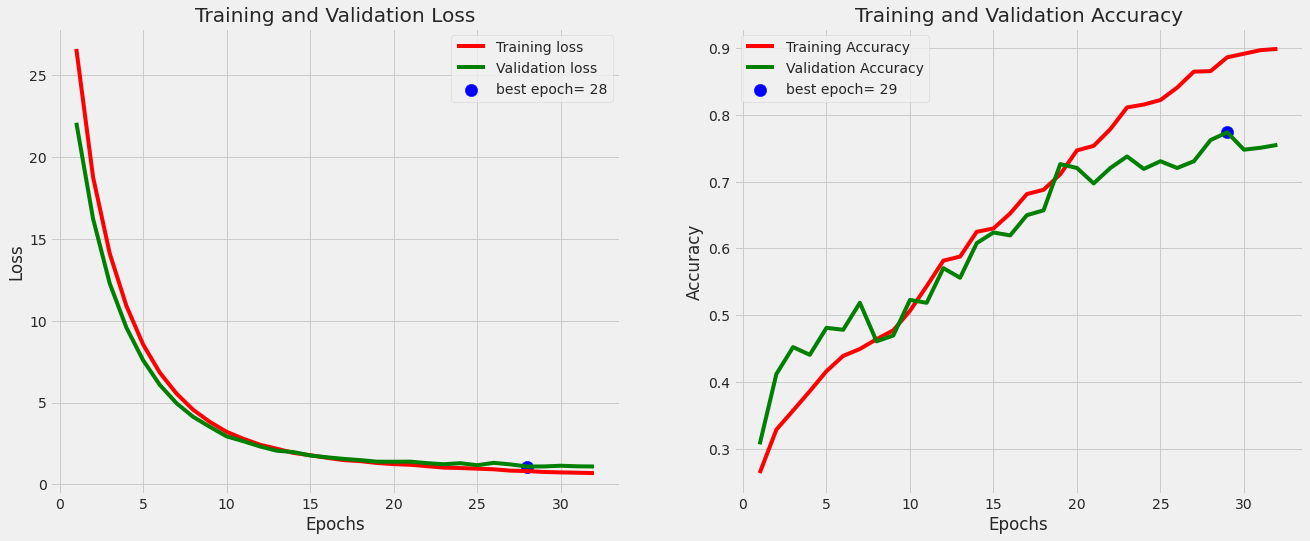

In [46]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

### Make predictions on test set. Calculate Confusion Matrix and Classification report

25/25 [==============================] - 7s 84ms/step
there were 390 in 1700 tests for an accuracy of  77.06


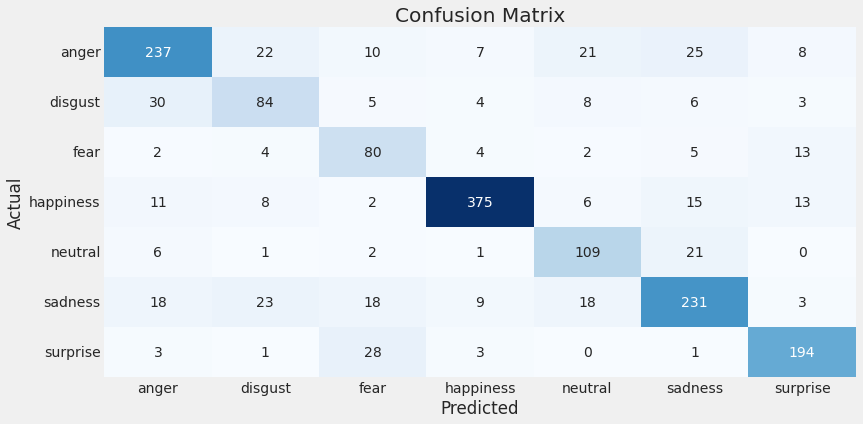

Classification Report:
----------------------
               precision    recall  f1-score   support

       anger     0.7720    0.7182    0.7441       330
     disgust     0.5874    0.6000    0.5936       140
        fear     0.5517    0.7273    0.6275       110
   happiness     0.9305    0.8721    0.9004       430
     neutral     0.6646    0.7786    0.7171       140
     sadness     0.7599    0.7219    0.7404       320
    surprise     0.8291    0.8435    0.8362       230

    accuracy                         0.7706      1700
   macro avg     0.7279    0.7516    0.7370      1700
weighted avg     0.7792    0.7706    0.7732      1700



In [47]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)